# Simple regression PoC

In this notebook we try to use the library instead of putting everything in a notebook

In [1]:
from typing import NamedTuple
import chex
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import fold_posterior, online_inference_loop, offline_inference_loop, estimate_elpd, rhat_summary
import arviz as az
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [2]:
class Theta(NamedTuple):
    beta: chex.Array
    sigsq: chex.Array

In [3]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 2.0, 3.0, 4.0])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [4]:
# y = y.at[23].set(75.0)  # outlier

In [5]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int = -1) -> chex.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set, use -1 for all data.
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    mask = 1.0 * ((jnp.arange(N) % 5) != fold_id)
    ll_contribs = tfd.Normal(loc=X@theta.beta, scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (mask * ll_contribs).sum()
    return lp + ll


# within-sample density log p(y|theta)
def log_p(theta):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    esq = ((X @ theta.beta - y) ** 2).sum()
    return -0.5 * (
        N * jnp.log(2 * jnp.pi)
        + N * jnp.log(sigsq)
        + esq/sigsq
    )


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = 1.0 * ((jnp.arange(N) % 5) == fold_id)
    npred = pred_mask.sum()
    esq = ((X @ theta.beta - y) ** 2) * pred_mask
    return -0.5 * (
        npred * jnp.log(2 * jnp.pi)
        + npred * jnp.log(sigsq)
        + esq.sum()/sigsq
    )


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

In [6]:
inference_key = jax.random.PRNGKey(42)

In [7]:
%%time

state, trace = fold_posterior(
    prng_key=inference_key,
    inference_loop=offline_inference_loop,
    logjoint_density=lambda theta: logjoint_density(theta, -1),
    log_p=log_p,
    make_initial_pos=make_initial_pos,
    num_chains=10,
    num_samples=1000,
    warmup_iter=2000)

CPU times: user 7.14 s, sys: 68.6 ms, total: 7.21 s
Wall time: 7.18 s


In [8]:
%%time

online_state = fold_posterior(
    prng_key=inference_key,
    inference_loop=online_inference_loop,
    logjoint_density=lambda theta: logjoint_density(theta, -1),
    log_p=log_p,
    make_initial_pos=make_initial_pos,
    num_chains=10,
    num_samples=1000,
    warmup_iter=2000)

TypeError: 'Theta' object is not callable

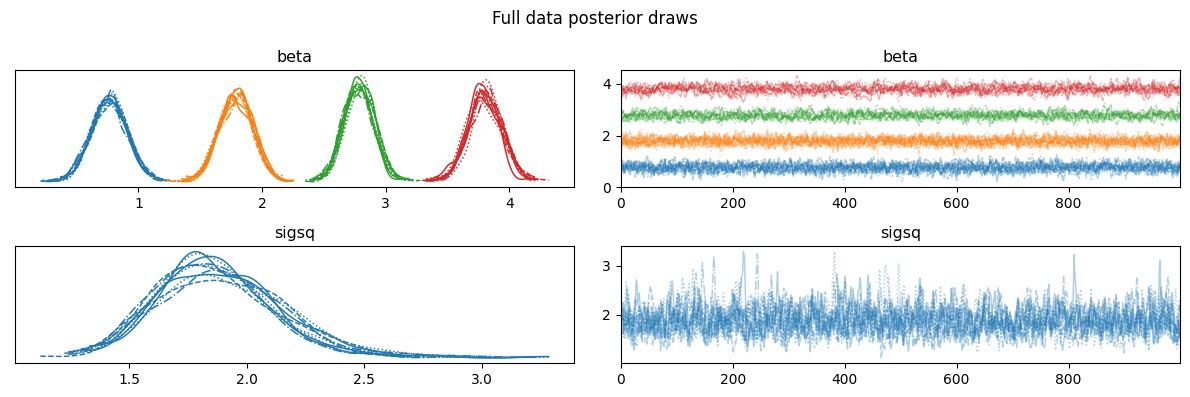

In [ ]:
trace_az = az.convert_to_inference_data(dict(beta=trace.position.beta, sigsq=jax.vmap(sigsq_t.forward)(trace.position.sigsq)))
az.plot_trace(trace_az)
plt.suptitle('Full data posterior draws')
plt.tight_layout()

In [ ]:
%%time

def make_fold(fold_id):
    results = fold_posterior(
        prng_key=inference_key,
        inference_loop=online_inference_loop,
        logjoint_density=lambda theta: logjoint_density(theta, fold_id),
        log_p=lambda theta: log_pred(theta, fold_id),
        make_initial_pos=make_initial_pos,
        num_chains=10,
        num_samples=2000,
        warmup_iter=1000)
    return results

online_fold_states = jax.vmap(make_fold)(jnp.arange(5))

CPU times: user 6.7 s, sys: 38.3 ms, total: 6.74 s
Wall time: 6.7 s


In [ ]:
estimate_elpd(online_fold_states)

-177.5559844970703

In [ ]:
rhat_summary(online_fold_states)

,fold,measure,beta[0],beta[1],beta[2],beta[3],sigsq,log p
0,Fold 0,Split Rhat,1.004729,1.003090,1.001378,1.001638,1.002931,1.002030
1,Fold 0,Folded Split Rhat,1.000225,1.000344,1.000089,0.999989,1.000200,1.002030
2,Fold 1,Split Rhat,1.004235,1.003935,1.003002,1.001966,1.004068,1.005659
3,Fold 1,Folded Split Rhat,1.000123,1.000396,1.000308,1.000800,1.000540,1.005659
4,Fold 2,Split Rhat,1.005523,1.002380,1.002399,1.001968,1.008226,1.007498
5,Fold 2,Folded Split Rhat,0.999975,1.000386,1.000471,1.000957,1.001552,1.007498
6,Fold 3,Split Rhat,1.004545,1.002787,1.003509,1.001956,1.004012,1.003799
7,Fold 3,Folded Split Rhat,1.000243,1.000529,1.000519,1.000468,1.001490,1.003799
8,Fold 4,Split Rhat,1.005509,1.006385,1.002367,1.001395,1.003474,1.004780
9,Fold 4,Folded Split Rhat,1.000622,1.000551,1.000358,1.000391,1.000513,1.004780


## Offline inference replay

In [ ]:
def replay_fold(fold_id, inference_key=inference_key):
    results, trace = fold_posterior(
        prng_key=inference_key,
        inference_loop=offline_inference_loop,
        logjoint_density=lambda theta: logjoint_density(theta, fold_id),
        log_p=lambda theta: log_pred(theta, fold_id),
        make_initial_pos=make_initial_pos,
        num_chains=10,
        num_samples=2000,
        warmup_iter=1000)
    pos = trace.position
    theta_dict = az.convert_to_inference_data(dict(beta=pos.beta, sigsq=jax.vmap(sigsq_t.forward)(pos.sigsq)))
    trace_az = az.convert_to_inference_data(theta_dict)
    return results, trace_az

In [ ]:
fold4_state, fold4_trace = replay_fold(4)

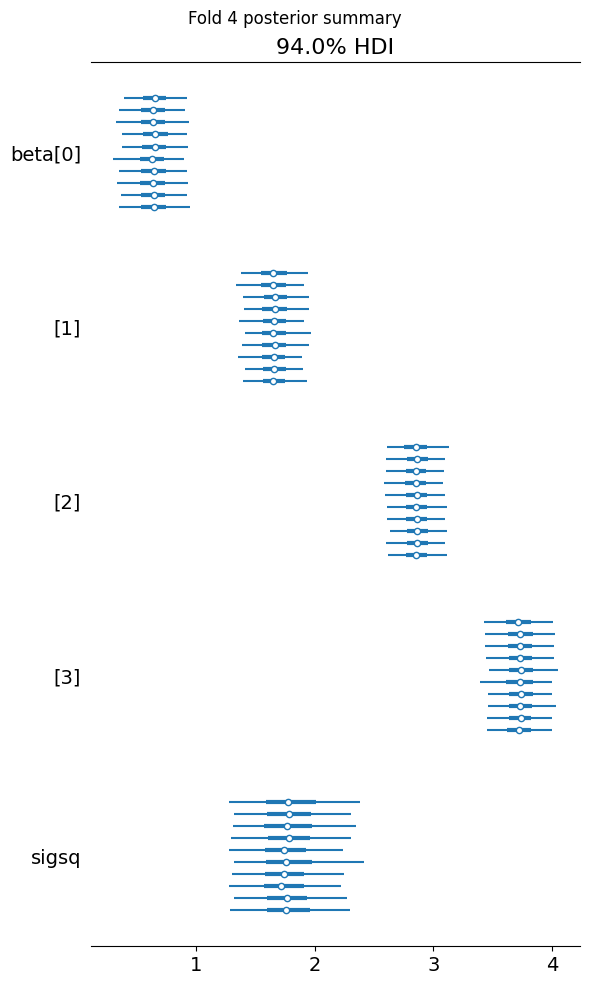

In [ ]:
az.plot_forest(fold4_trace)
plt.suptitle(f"Fold 4 posterior summary")
plt.tight_layout()

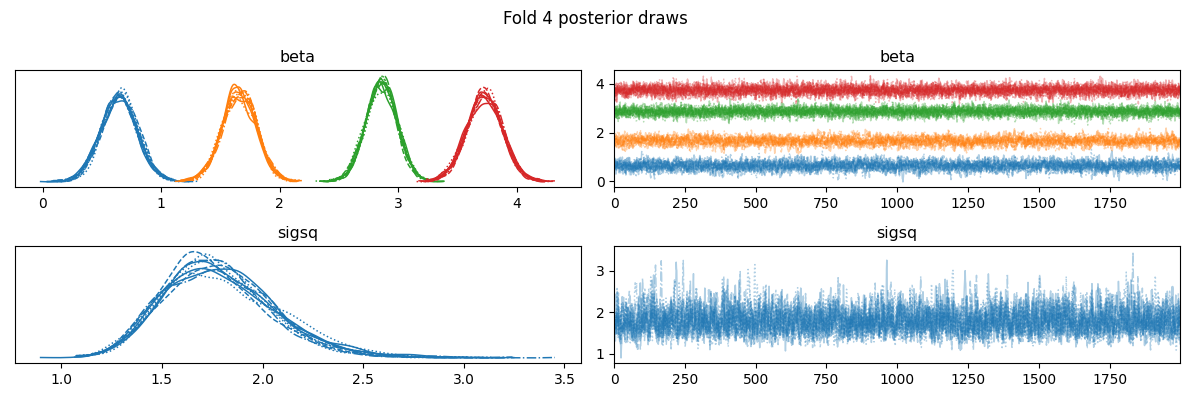

In [ ]:
az.plot_trace(fold4_trace);
plt.suptitle('Fold 4 posterior draws')
plt.tight_layout()